# Read the Data  from excel file

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

## Split the data in training and testing and scale it

In [ ]:
# Load data from Excel
file_path = 'Simulation-results.xlsx'
data = pd.read_excel(file_path)

# Split the data into inputs (X) and outputs (Y1, Y2, Y3)
X = data.iloc[:, :4].values  # First 4 columns as input features
Y1 = data.iloc[:, 4].values  # Output omega_1
Y2 = data.iloc[:, 5].values  # Output omega_2
Y3 = data.iloc[:, 6].values  # Output omega_3

# Combine Y1, Y2, Y3 into a single array for multi-output
Y = np.column_stack((Y1, Y2, Y3))

# Normalize the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Split Y_train and Y_test into Y1, Y2, Y3 for both training and testing
Y1_train, Y2_train, Y3_train = Y_train[:, 0], Y_train[:, 1], Y_train[:, 2]
Y1_test, Y2_test, Y3_test = Y_test[:, 0], Y_test[:, 1], Y_test[:, 2]

## Function to calculate the metrics

In [ ]:
# Define the function to calculate metrics
def calculate_metrics(y_true, y_pred, n, k):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    vaf = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    ns = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2))
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    pi = np.percentile(np.abs(y_true - y_pred), 95)
    rsr = rmse / np.std(y_true)
    wi = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_pred - y_true.mean()) + np.abs(y_true - y_true.mean())) ** 2))

    return r2, adj_r2, wmape, ns, rmse, vaf, pi, rsr, wi, mae

# DNN Model

## Model Details
Hidden Layers: 6 layers - 10 neurons each (relu)  
Output Layer: 3 neurons (no activation)  
Learning Rate: 0.01  
Optimizer: Adam  
Epochs: 1000  
Loss: Mean Squared Error (MSE)  
Early Stopping: Patience(20)  

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(10, input_dim=4, activation='relu'))  # First layer with 10 neurons

# Add Hidden layers
for _ in range(5):  # Adding 5 more hidden layers
    model.add(Dense(10, activation='relu'))

# 3 outputs (omega_1, omega_2, omega_3)
model.add(Dense(3))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, Y_train, epochs=1000, verbose=1, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Predict the outputs
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Separate the predictions for Y1, Y2, Y3
Y1_train_pred_dnn, Y2_train_pred_dnn, Y3_train_pred_dnn = predictions_train[:, 0], predictions_train[:, 1], predictions_train[:, 2]
Y1_test_pred_dnn, Y2_test_pred_dnn, Y3_test_pred_dnn = predictions_test[:, 0], predictions_test[:, 1], predictions_test[:, 2]

Epoch 1/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10.5965 - val_loss: 0.1620
Epoch 2/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1404 - val_loss: 0.0660
Epoch 3/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0583 - val_loss: 0.0413
Epoch 4/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0383 - val_loss: 0.0365
Epoch 5/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0350 - val_loss: 0.0276
Epoch 6/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0328 - val_loss: 0.0276
Epoch 7/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0264 - val_loss: 0.0326
Epoch 8/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0235 - val_loss: 0.0165
Epoch 9/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0204 - val_loss: 0.0151
Epoch 10/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0131
Epoch 11/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0120
Epoch 12/1000
439/439 ━━━━━━━

## Evaluate the metrics

In [ ]:
k_dnn = X_train.shape[1]
# training metrics
Y1_train_metrics_dnn = calculate_metrics(Y1_train, Y1_train_pred_dnn, len(Y1_train), k_dnn)
Y2_train_metrics_dnn = calculate_metrics(Y2_train, Y2_train_pred_dnn, len(Y2_train), k_dnn)
Y3_train_metrics_dnn = calculate_metrics(Y3_train, Y3_train_pred_dnn, len(Y3_train), k_dnn)
# testing metrics
Y1_test_metrics_dnn = calculate_metrics(Y1_test, Y1_test_pred_dnn, len(Y1_test), k_dnn)
Y2_test_metrics_dnn = calculate_metrics(Y2_test, Y2_test_pred_dnn, len(Y1_test), k_dnn)
Y3_test_metrics_dnn = calculate_metrics(Y3_test, Y3_test_pred_dnn, len(Y1_test), k_dnn)

ideal_values = [1, 1, 0, 1, 0, 1, 0, 0, 1, 0]

# Print the metrics with 4 decimal places
print("\t\tOmega_1\t\t\t\tOmega_2\t\t\t\tOmega_3\t\t\tIdeal")
print("\tTraining\tTesting\t\tTraining\tTesting\t\tTraining\tTesting")
metrics_names = ["R²", "Adj R²", "WMAPE", "NS", "RMSE", "VAF", "PI", "RSR", "WI", "MAE"]
for i, name in enumerate(metrics_names):
  print(f"{name}\t{Y1_train_metrics_dnn[i]:.4f}",
        f"\t\t{Y2_train_metrics_dnn[i]:.4f}",
        f"\t\t{Y3_train_metrics_dnn[i]:.4f}",
        f"\t\t{Y1_test_metrics_dnn[i]:.4f}",
        f"\t\t{Y2_test_metrics_dnn[i]:.4f}",
        f"\t\t{Y3_test_metrics_dnn[i]:.4f}",
        f"\t\t{ideal_values[i]}")

		Omega_1				Omega_2				Omega_3			Ideal
	Training	Testing		Training	Testing		Training	Testing
R²	0.9938 		0.9997 		0.9991 		0.9933 		0.9997 		0.9990 		1
Adj R²	0.9938 		0.9997 		0.9991 		0.9933 		0.9997 		0.9990 		1
WMAPE	0.0125 		0.0054 		0.0072 		0.0128 		0.0054 		0.0074 		0
NS	0.9938 		0.9997 		0.9991 		0.9933 		0.9997 		0.9990 		1
RMSE	0.0582 		0.0549 		0.0978 		0.0595 		0.0541 		0.1034 		0
VAF	0.9950 		0.9997 		0.9991 		0.9946 		0.9997 		0.9990 		1
PI	0.1106 		0.1135 		0.2144 		0.1181 		0.1116 		0.2371 		0
RSR	0.0787 		0.0173 		0.0295 		0.0821 		0.0173 		0.0316 		0
WI	0.9985 		0.9999 		0.9998 		0.9983 		0.9999 		0.9998 		1
MAE	0.0470 		0.0418 		0.0663 		0.0478 		0.0414 		0.0686 		0


# XGBoost

 ## Model Details
 Loss function : Mean Squared Error  
 n_estimators : 100   
 learning rate : 0.1   
 maximum depth = 5  

In [ ]:
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=60, learning_rate=0.1, max_depth=3, subsample=0.5, colsample_bytree=0.5, reg_alpha=10, reg_lambda=10, random_state=42))

# Train each model
model.fit(X_train, Y_train)

# Predict on the training set
y_train_pred_xgb = model.predict(X_train)

# Predict on the test set
y_test_pred_xgb = model.predict(X_test)

# Separate the predictions for Y1, Y2, Y3
Y1_train_pred_xgb, Y2_train_pred_xgb, Y3_train_pred_xgb = y_train_pred_xgb[:, 0], y_train_pred_xgb[:, 1], y_train_pred_xgb[:, 2]
Y1_test_pred_xgb, Y2_test_pred_xgb, Y3_test_pred_xgb = y_test_pred_xgb[:, 0], y_test_pred_xgb[:, 1], y_test_pred_xgb[:, 2]


## Evaluate metrics

In [ ]:
#XGBoost model
k_dnn = X_train.shape[1]
# training metrics
Y1_train_metrics_xgb = calculate_metrics(Y1_train, Y1_train_pred_xgb, len(Y1_train), k_dnn)
Y2_train_metrics_xgb = calculate_metrics(Y2_train, Y2_train_pred_xgb, len(Y2_train), k_dnn)
Y3_train_metrics_xgb = calculate_metrics(Y3_train, Y3_train_pred_xgb, len(Y3_train), k_dnn)
# testing metrics
Y1_test_metrics_xgb = calculate_metrics(Y1_test, Y1_test_pred_xgb, len(Y1_test), k_dnn)
Y2_test_metrics_xgb = calculate_metrics(Y2_test, Y2_test_pred_xgb, len(Y1_test), k_dnn)
Y3_test_metrics_xgb = calculate_metrics(Y3_test, Y3_test_pred_xgb, len(Y1_test), k_dnn)

ideal_values = [1, 1, 0, 1, 0, 1, 0, 0, 1, 0]

# Print the metrics with 4 decimal places
print("\t\tOmega_1\t\t\t\tOmega_2\t\t\t\tOmega_3\t\t\tIdeal")
print("\tTraining\tTesting\t\tTraining\tTesting\t\tTraining\tTesting")
metrics_names = ["R²", "Adj R²", "WMAPE", "NS", "RMSE", "VAF", "PI", "RSR", "WI", "MAE"]
for i, name in enumerate(metrics_names):
  print(f"{name}\t{Y1_train_metrics_xgb[i]:.4f}",
        f"\t\t{Y2_train_metrics_xgb[i]:.4f}",
        f"\t\t{Y3_train_metrics_xgb[i]:.4f}",
        f"\t\t{Y1_test_metrics_xgb[i]:.4f}",
        f"\t\t{Y2_test_metrics_xgb[i]:.4f}",
        f"\t\t{Y3_test_metrics_xgb[i]:.4f}",
        f"\t\t{ideal_values[i]}")

		Omega_1				Omega_2				Omega_3			Ideal
	Training	Testing		Training	Testing		Training	Testing
R²	0.9857 		0.9880 		0.9929 		0.9855 		0.9879 		0.9930 		1
Adj R²	0.9857 		0.9880 		0.9929 		0.9855 		0.9879 		0.9929 		1
WMAPE	0.0163 		0.0322 		0.0205 		0.0162 		0.0322 		0.0203 		0
NS	0.9857 		0.9880 		0.9929 		0.9855 		0.9879 		0.9930 		1
RMSE	0.0885 		0.3474 		0.2781 		0.0872 		0.3439 		0.2744 		0
VAF	0.9857 		0.9880 		0.9929 		0.9855 		0.9879 		0.9930 		1
PI	0.1871 		0.6908 		0.5924 		0.1808 		0.6962 		0.5737 		0
RSR	0.1196 		0.1096 		0.0840 		0.1203 		0.1100 		0.0839 		0
WI	0.9961 		0.9967 		0.9981 		0.9960 		0.9967 		0.9981 		1
MAE	0.0613 		0.2505 		0.1894 		0.0604 		0.2488 		0.1869 		0


# SVM

## Model Details

In [ ]:
# Define the single set of hyperparameters
C = 100
gamma = 0.1
epsilon = 0.01

# Define the base SVR model with the chosen parameters
svr = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

# Wrap the SVR in a MultiOutputRegressor
multi_svm = MultiOutputRegressor(svr)

# Train the model
multi_svm.fit(X_train, Y_train)

# Make predictions
y_train_pred_svm = multi_svm.predict(X_train)
y_test_pred_svm = multi_svm.predict(X_test)


## Evaluate metrics

In [ ]:
# Separate the predictions for Y1, Y2, Y3
Y1_train_pred_svm, Y2_train_pred_svm, Y3_train_pred_svm = y_train_pred_svm[:, 0], y_train_pred_svm[:, 1], y_train_pred_svm[:, 2]
Y1_test_pred_svm, Y2_test_pred_svm, Y3_test_pred_svm = y_test_pred_svm[:, 0], y_test_pred_svm[:, 1], y_test_pred_svm[:, 2]

k_svm = X_train.shape[1]
# training metrics
Y1_train_metrics_svm = calculate_metrics(Y1_train, Y1_train_pred_svm, len(Y1_train), k_svm)
Y2_train_metrics_svm = calculate_metrics(Y2_train, Y2_train_pred_svm, len(Y2_train), k_svm)
Y3_train_metrics_svm = calculate_metrics(Y3_train, Y3_train_pred_svm, len(Y3_train), k_svm)
# testing metrics
Y1_test_metrics_svm = calculate_metrics(Y1_test, Y1_test_pred_svm, len(Y1_test), k_svm)
Y2_test_metrics_svm = calculate_metrics(Y2_test, Y2_test_pred_svm, len(Y1_test), k_svm)
Y3_test_metrics_svm = calculate_metrics(Y3_test, Y3_test_pred_svm, len(Y1_test), k_svm)

ideal_values = [1, 1, 0, 1, 0, 1, 0, 0, 1, 0]

# Print the metrics with 4 decimal places
print("\t\tOmega_1\t\t\t\tOmega_2\t\t\t\tOmega_3\t\t\tIdeal")
print("\tTraining\tTesting\t\tTraining\tTesting\t\tTraining\tTesting")
metrics_names = ["R²", "Adj R²", "WMAPE", "NS", "RMSE", "VAF", "PI", "RSR", "WI", "MAE"]
for i, name in enumerate(metrics_names):
  print(f"{name}\t{Y1_train_metrics_svm[i]:.4f}",
        f"\t\t{Y2_train_metrics_svm[i]:.4f}",
        f"\t\t{Y3_train_metrics_svm[i]:.4f}",
        f"\t\t{Y1_test_metrics_svm[i]:.4f}",
        f"\t\t{Y2_test_metrics_svm[i]:.4f}",
        f"\t\t{Y3_test_metrics_svm[i]:.4f}",
        f"\t\t{ideal_values[i]}")

		Omega_1				Omega_2				Omega_3			Ideal
	Training	Testing		Training	Testing		Training	Testing
R²	0.9800 		0.9226 		0.8811 		0.9790 		0.9185 		0.8759 		1
Adj R²	0.9800 		0.9225 		0.8811 		0.9789 		0.9184 		0.8757 		1
WMAPE	0.0136 		0.0522 		0.0587 		0.0139 		0.0538 		0.0600 		0
NS	0.9800 		0.9226 		0.8811 		0.9790 		0.9185 		0.8759 		1
RMSE	0.1047 		0.8825 		1.1416 		0.1051 		0.8923 		1.1518 		0
VAF	0.9825 		0.9347 		0.9023 		0.9817 		0.9314 		0.8983 		1
PI	0.2645 		2.4092 		2.5480 		0.2700 		2.4151 		2.5482 		0
RSR	0.1415 		0.2783 		0.3448 		0.1450 		0.2855 		0.3523 		0
WI	0.9949 		0.9800 		0.9699 		0.9946 		0.9789 		0.9686 		1
MAE	0.0510 		0.4056 		0.5424 		0.0521 		0.4154 		0.5536 		0


# Predicted vs Actual Values for each model

## DNN Model

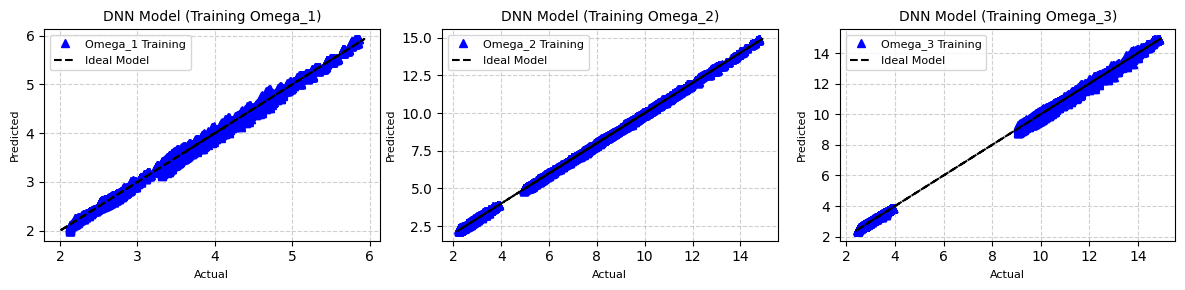

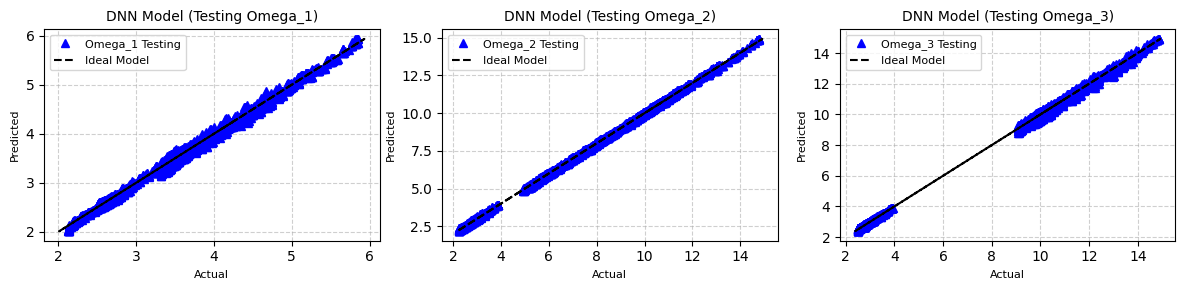

In [ ]:
import matplotlib.pyplot as plt
#Training
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 1
ax1.plot(Y1_train_pred_dnn, Y1_train, label='Omega_1 Training', color='blue', marker='^', linestyle='')
ax1.plot(Y1_train, Y1_train, label='Ideal Model', color='black', linestyle='--')
ax1.set_title("DNN Model (Training Omega_1)", fontsize=10)
ax1.set_ylabel("Predicted", fontsize=8)
ax1.set_xlabel("Actual", fontsize=8)
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, linestyle='--', alpha=0.6)

# Graph 2
ax2.plot(Y2_train_pred_dnn, Y2_train, label='Omega_2 Training', color='blue', marker='^', linestyle='')
ax2.plot(Y2_train, Y2_train, label='Ideal Model', color='black', linestyle='--')
ax2.set_title("DNN Model (Training Omega_2)", fontsize=10)
ax2.set_ylabel("Predicted", fontsize=8)
ax2.set_xlabel("Actual", fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, linestyle='--', alpha=0.6)

# Graph 3
ax3.plot(Y3_train_pred_dnn, Y3_train, label='Omega_3 Training', color='blue', marker='^', linestyle='')
ax3.plot(Y3_train, Y3_train, label='Ideal Model', color='black', linestyle='--')
ax3.set_title("DNN Model (Training Omega_3)", fontsize=10)
ax3.set_ylabel("Predicted", fontsize=8)
ax3.set_xlabel("Actual", fontsize=8)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()


# Testing
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 4
ax4.plot(Y1_test_pred_dnn, Y1_test, label='Omega_1 Testing', color='blue', marker='^', linestyle='')
ax4.plot(Y1_test, Y1_test, label='Ideal Model', color='black', linestyle='--')
ax4.set_title("DNN Model (Testing Omega_1)", fontsize=10)
ax4.set_ylabel("Predicted", fontsize=8)
ax4.set_xlabel("Actual", fontsize=8)
ax4.legend(loc='upper left', fontsize=8)
ax4.grid(True, linestyle='--', alpha=0.6)

# Graph 5
ax5.plot(Y2_test_pred_dnn, Y2_test, label='Omega_2 Testing', color='blue', marker='^', linestyle='')
ax5.plot(Y2_test, Y2_test, label='Ideal Model', color='black', linestyle='--')
ax5.set_title("DNN Model (Testing Omega_2)", fontsize=10)
ax5.set_ylabel("Predicted", fontsize=8)
ax5.set_xlabel("Actual", fontsize=8)
ax5.legend(loc='upper left', fontsize=8)
ax5.grid(True, linestyle='--', alpha=0.6)

# Graph 6
ax6.plot(Y3_test_pred_dnn, Y3_test, label='Omega_3 Testing', color='blue', marker='^', linestyle='')
ax6.plot(Y3_test, Y3_test, label='Ideal Model', color='black', linestyle='--')
ax6.set_title("DNN Model (Testing Omega_3)", fontsize=10)
ax6.set_ylabel("Predicted", fontsize=8)
ax6.set_xlabel("Actual", fontsize=8)
ax6.legend(loc='upper left', fontsize=8)
ax6.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

## XGBoost Model

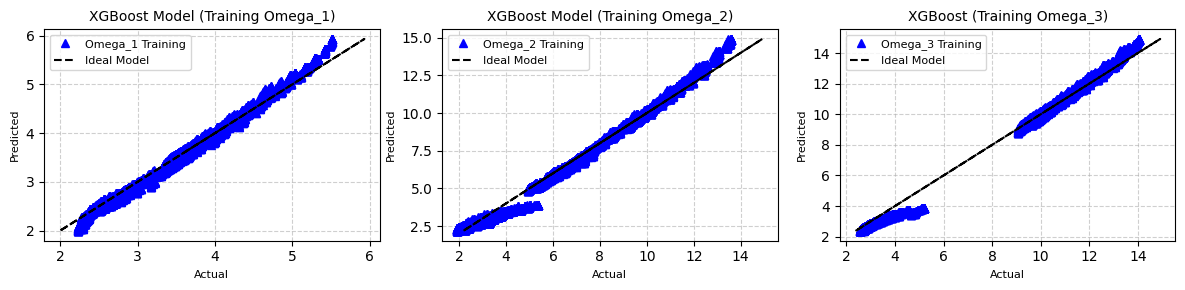

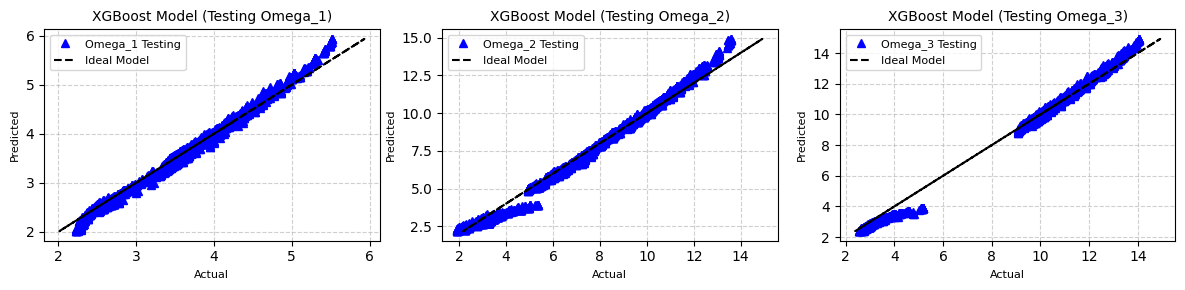

In [ ]:
import matplotlib.pyplot as plt
#Training
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 1
ax1.plot(Y1_train_pred_xgb, Y1_train, label='Omega_1 Training', color='blue', marker='^', linestyle='')
ax1.plot(Y1_train, Y1_train, label='Ideal Model', color='black', linestyle='--')
ax1.set_title("XGBoost Model (Training Omega_1)", fontsize=10)
ax1.set_ylabel("Predicted", fontsize=8)
ax1.set_xlabel("Actual", fontsize=8)
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, linestyle='--', alpha=0.6)

# Graph 2
ax2.plot(Y2_train_pred_xgb, Y2_train, label='Omega_2 Training', color='blue', marker='^', linestyle='')
ax2.plot(Y2_train, Y2_train, label='Ideal Model', color='black', linestyle='--')
ax2.set_title("XGBoost Model (Training Omega_2)", fontsize=10)
ax2.set_ylabel("Predicted", fontsize=8)
ax2.set_xlabel("Actual", fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, linestyle='--', alpha=0.6)

# Graph 3
ax3.plot(Y3_train_pred_xgb, Y3_train, label='Omega_3 Training', color='blue', marker='^', linestyle='')
ax3.plot(Y3_train, Y3_train, label='Ideal Model', color='black', linestyle='--')
ax3.set_title("XGBoost (Training Omega_3)", fontsize=10)
ax3.set_ylabel("Predicted", fontsize=8)
ax3.set_xlabel("Actual", fontsize=8)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()


# Testing
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 4
ax4.plot(Y1_test_pred_xgb, Y1_test, label='Omega_1 Testing', color='blue', marker='^', linestyle='')
ax4.plot(Y1_test, Y1_test, label='Ideal Model', color='black', linestyle='--')
ax4.set_title("XGBoost Model (Testing Omega_1)", fontsize=10)
ax4.set_ylabel("Predicted", fontsize=8)
ax4.set_xlabel("Actual", fontsize=8)
ax4.legend(loc='upper left', fontsize=8)
ax4.grid(True, linestyle='--', alpha=0.6)

# Graph 5
ax5.plot(Y2_test_pred_xgb, Y2_test, label='Omega_2 Testing', color='blue', marker='^', linestyle='')
ax5.plot(Y2_test, Y2_test, label='Ideal Model', color='black', linestyle='--')
ax5.set_title("XGBoost Model (Testing Omega_2)", fontsize=10)
ax5.set_ylabel("Predicted", fontsize=8)
ax5.set_xlabel("Actual", fontsize=8)
ax5.legend(loc='upper left', fontsize=8)
ax5.grid(True, linestyle='--', alpha=0.6)

# Graph 6
ax6.plot(Y3_test_pred_xgb, Y3_test, label='Omega_3 Testing', color='blue', marker='^', linestyle='')
ax6.plot(Y3_test, Y3_test, label='Ideal Model', color='black', linestyle='--')
ax6.set_title("XGBoost Model (Testing Omega_3)", fontsize=10)
ax6.set_ylabel("Predicted", fontsize=8)
ax6.set_xlabel("Actual", fontsize=8)
ax6.legend(loc='upper left', fontsize=8)
ax6.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

## SVM

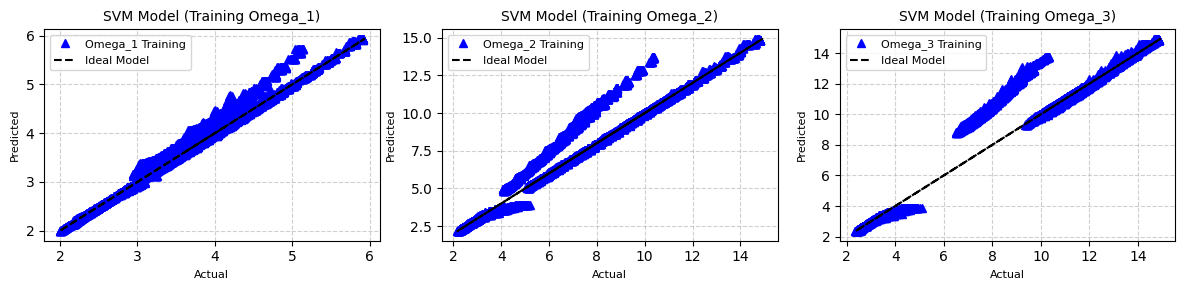

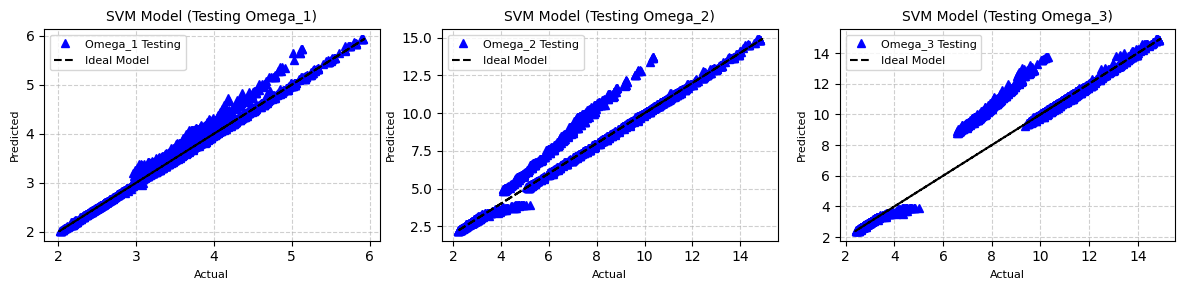

In [ ]:
import matplotlib.pyplot as plt
#Training
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 1
ax1.plot(Y1_train_pred_svm, Y1_train, label='Omega_1 Training', color='blue', marker='^', linestyle='')
ax1.plot(Y1_train, Y1_train, label='Ideal Model', color='black', linestyle='--')
ax1.set_title("SVM Model (Training Omega_1)", fontsize=10)
ax1.set_ylabel("Predicted", fontsize=8)
ax1.set_xlabel("Actual", fontsize=8)
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, linestyle='--', alpha=0.6)

# Graph 2
ax2.plot(Y2_train_pred_svm, Y2_train, label='Omega_2 Training', color='blue', marker='^', linestyle='')
ax2.plot(Y2_train, Y2_train, label='Ideal Model', color='black', linestyle='--')
ax2.set_title("SVM Model (Training Omega_2)", fontsize=10)
ax2.set_ylabel("Predicted", fontsize=8)
ax2.set_xlabel("Actual", fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, linestyle='--', alpha=0.6)

# Graph 3
ax3.plot(Y3_train_pred_svm, Y3_train, label='Omega_3 Training', color='blue', marker='^', linestyle='')
ax3.plot(Y3_train, Y3_train, label='Ideal Model', color='black', linestyle='--')
ax3.set_title("SVM Model (Training Omega_3)", fontsize=10)
ax3.set_ylabel("Predicted", fontsize=8)
ax3.set_xlabel("Actual", fontsize=8)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()


# Testing
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

# Graph 4
ax4.plot(Y1_test_pred_svm, Y1_test, label='Omega_1 Testing', color='blue', marker='^', linestyle='')
ax4.plot(Y1_test, Y1_test, label='Ideal Model', color='black', linestyle='--')
ax4.set_title("SVM Model (Testing Omega_1)", fontsize=10)
ax4.set_ylabel("Predicted", fontsize=8)
ax4.set_xlabel("Actual", fontsize=8)
ax4.legend(loc='upper left', fontsize=8)
ax4.grid(True, linestyle='--', alpha=0.6)

# Graph 5
ax5.plot(Y2_test_pred_svm, Y2_test, label='Omega_2 Testing', color='blue', marker='^', linestyle='')
ax5.plot(Y2_test, Y2_test, label='Ideal Model', color='black', linestyle='--')
ax5.set_title("SVM Model (Testing Omega_2)", fontsize=10)
ax5.set_ylabel("Predicted", fontsize=8)
ax5.set_xlabel("Actual", fontsize=8)
ax5.legend(loc='upper left', fontsize=8)
ax5.grid(True, linestyle='--', alpha=0.6)

# Graph 6
ax6.plot(Y3_test_pred_svm, Y3_test, label='Omega_3 Testing', color='blue', marker='^', linestyle='')
ax6.plot(Y3_test, Y3_test, label='Ideal Model', color='black', linestyle='--')
ax6.set_title("SVM Model (Testing Omega_3)", fontsize=10)
ax6.set_ylabel("Predicted", fontsize=8)
ax6.set_xlabel("Actual", fontsize=8)
ax6.legend(loc='upper left', fontsize=8)
ax6.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

# Taylor Diagram for each model

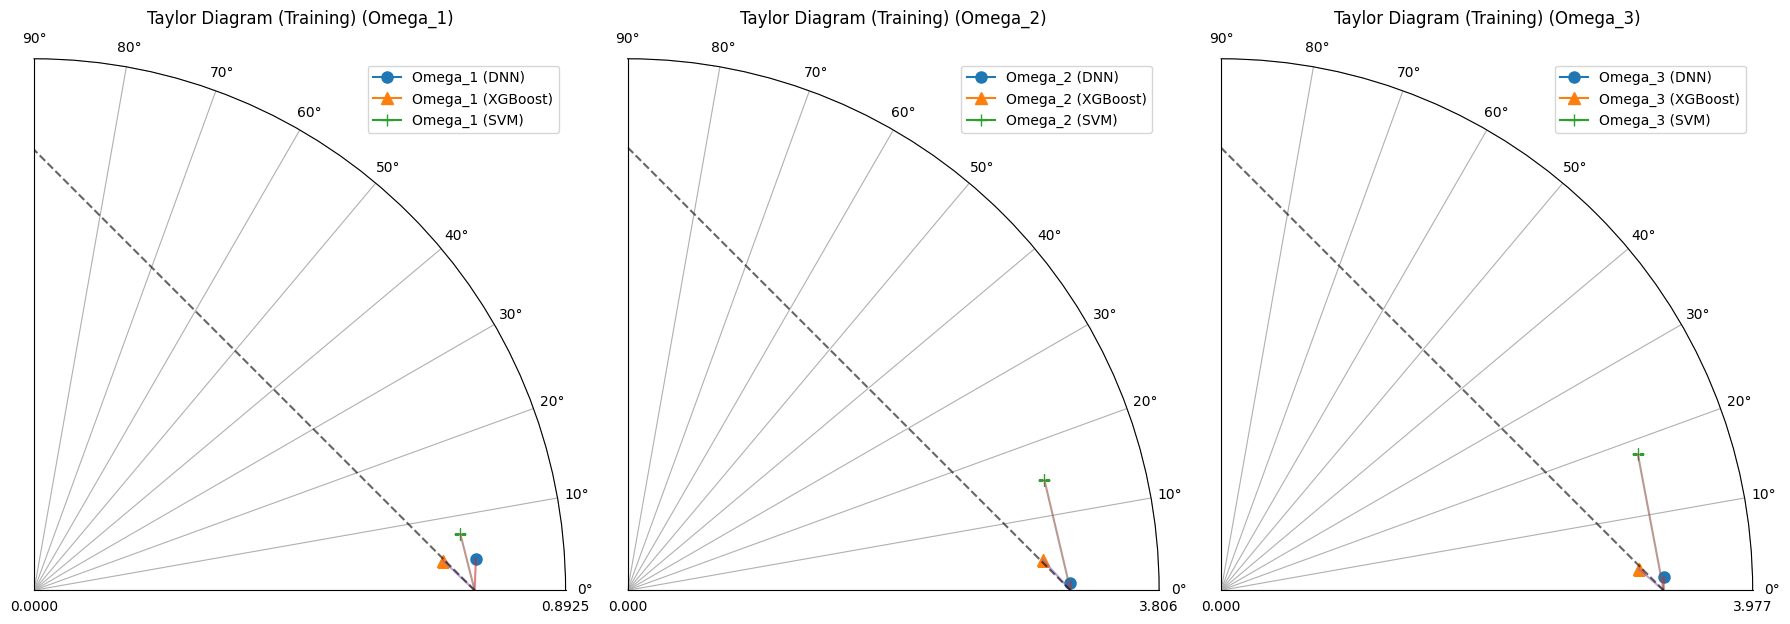

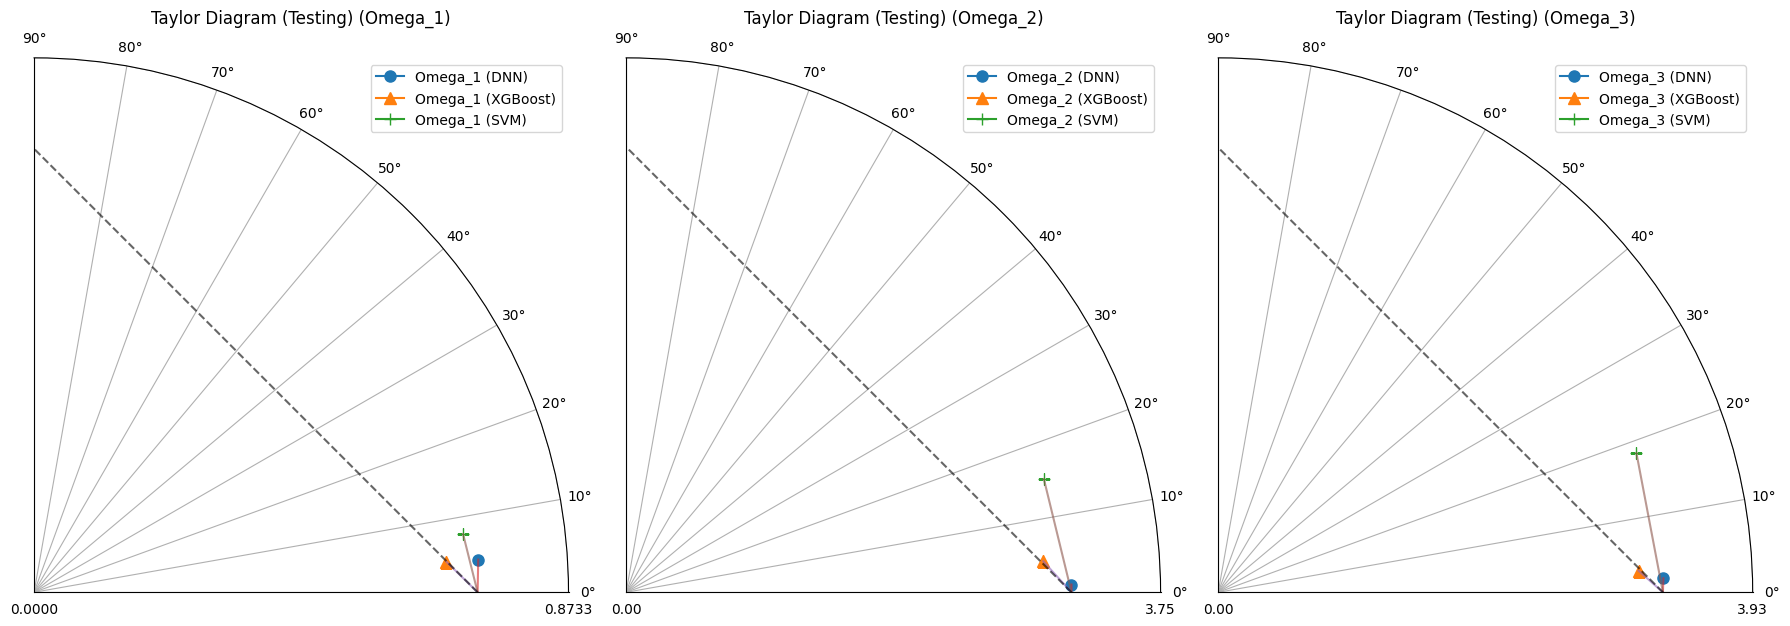

In [ ]:
import matplotlib.pyplot as plt

# Function to compute Taylor diagram components (standard deviation, correlation, RMS error)
def taylor_diagram(ax, ref_data, model_data1, model_data2, model_data3, label1, label2, label3, marker1, marker2, marker3):
    # Standard deviation of the reference and model data
    std_ref = np.std(ref_data)
    std_model1 = np.std(model_data1)
    std_model2 = np.std(model_data2)
    std_model3 = np.std(model_data3)

    # RMS Error (normalized by standard deviation)
    rms_error1 = np.sqrt(np.mean((model_data1 - ref_data) ** 2)) / std_ref
    rms_error2 = np.sqrt(np.mean((model_data2 - ref_data) ** 2)) / std_ref
    rms_error3 = np.sqrt(np.mean((model_data3 - ref_data) ** 2)) / std_ref

    # Correlation coefficient
    correlation1 = np.corrcoef(ref_data, model_data1)[0, 1]
    correlation2 = np.corrcoef(ref_data, model_data2)[0, 1]
    correlation3 = np.corrcoef(ref_data, model_data3)[0, 1]

    # Convert correlation coefficient to azimuthal angle (radians)
    angle1 = np.arccos(correlation1)  # angle between 0 and pi
    angle2 = np.arccos(correlation2)  # angle between 0 and pi
    angle3 = np.arccos(correlation3)  # angle between 0 and pi

    # Plot the model points (on the Taylor diagram)
    ax.plot(angle1, std_model1, marker=marker1, label=label1, markersize=8)
    ax.plot(angle2, std_model2, marker=marker2, label=label2, markersize=8)
    ax.plot(angle3, std_model3, marker=marker3, label=label3, markersize=8)

    # Plot RMS Error (distance from the reference to the model)
    ax.plot([0, angle1], [std_ref, std_model1], linestyle='-', alpha=0.6)
    ax.plot([0, angle2], [std_ref, std_model2], linestyle='-', alpha=0.6)
    ax.plot([0, angle3], [std_ref, std_model3], linestyle='-', alpha=0.6)

    # Draw a line indicating the reference
    ax.plot([0, np.pi/2], [std_ref, std_ref], color='black', linestyle='--', alpha=0.6)

    return rms_error1, rms_error2, rms_error3, correlation1, correlation2, correlation3, std_model1, std_model2, std_model3

# Create subplots for 3 Taylor diagrams in the first quadrant
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

# Set the angular limits to only cover the first quadrant
for ax in [ax1, ax2, ax3]:
    ax.set_theta_zero_location('E')  # Zero at the left
    ax.set_theta_direction(1)  # Clockwise direction for angles
    ax.set_thetamin(0)  # Set minimum angle (0 degrees)
    ax.set_thetamax(90)  # Set maximum angle (90 degrees)

# Graph 1 - Omega_1
rms_dnn_train, rms_xgb_train, rms_svm_train, corr_dnn_train, corr_xgb_train, corr_svm_train, std_dnn_train, std_xgb_train, std_svm_train = taylor_diagram(ax1, Y1_train, Y1_train_pred_dnn, Y1_train_pred_xgb, Y1_train_pred_svm, 'Omega_1 (DNN)', 'Omega_1 (XGBoost)', 'Omega_1 (SVM)', 'o', '^', '+')
ax1.set_title("Taylor Diagram (Training) (Omega_1)", fontsize=12)
ax1.set_rticks([0, std_dnn_train * 1.2])  # Set radial ticks based on std

# Graph 2 - Omega_2
rms_dnn_train, rms_xgb_train, rms_svm_train, corr_dnn_train, corr_xgb_train, corr_svm_train, std_dnn_train, std_xgb_train, std_svm_train = taylor_diagram(ax2, Y2_train, Y2_train_pred_dnn, Y2_train_pred_xgb, Y2_train_pred_svm, 'Omega_2 (DNN)', 'Omega_2 (XGBoost)', 'Omega_2 (SVM)', 'o', '^', '+')
ax2.set_title("Taylor Diagram (Training) (Omega_2)", fontsize=12)
ax2.set_rticks([0, std_dnn_train * 1.2])  # Set radial ticks based on std

# Graph 3 - Omega_3
rms_dnn_train, rms_xgb_train, rms_svm_train, corr_dnn_train, corr_xgb_train, corr_svm_train, std_dnn_train, std_xgb_train, std_svm_train = taylor_diagram(ax3, Y3_train, Y3_train_pred_dnn, Y3_train_pred_xgb, Y3_train_pred_svm, 'Omega_3 (DNN)', 'Omega_3 (XGBoost)', 'Omega_3 (SVM)', 'o', '^', '+')
ax3.set_title("Taylor Diagram (Training) (Omega_3)", fontsize=12)
ax3.set_rticks([0, std_dnn_train * 1.2])  # Set radial ticks based on std

# Add legends manually for all subplots
ax1.legend(loc='upper right', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax3.legend(loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Create subplots for 3 Taylor diagrams in the first quadrant
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

# Set the angular limits to only cover the first quadrant
for ax in [ax1, ax2, ax3]:
    ax.set_theta_zero_location('E')  # Zero at the left
    ax.set_theta_direction(1)  # Clockwise direction for angles
    ax.set_thetamin(0)  # Set minimum angle (0 degrees)
    ax.set_thetamax(90)  # Set maximum angle (90 degrees)

# Graph 1 - Omega_1
rms_dnn_test, rms_xgb_test, rms_svm_test, corr_dnn_test, corr_xgb_test, corr_svm_test, std_dnn_test, std_xgb_test, std_svm_test = taylor_diagram(ax1, Y1_test, Y1_test_pred_dnn, Y1_test_pred_xgb, Y1_test_pred_svm, 'Omega_1 (DNN)', 'Omega_1 (XGBoost)', 'Omega_1 (SVM)', 'o', '^', '+')
ax1.set_title("Taylor Diagram (Testing) (Omega_1)", fontsize=12)
ax1.set_rticks([0, std_dnn_test * 1.2])  # Set radial ticks based on std

# Graph 2 - Omega_2
rms_dnn_test, rms_xgb_test, rms_svm_test, corr_dnn_test, corr_xgb_test, corr_svm_test, std_dnn_test, std_xgb_test, std_svm_test = taylor_diagram(ax2, Y2_test, Y2_test_pred_dnn, Y2_test_pred_xgb, Y2_test_pred_svm, 'Omega_2 (DNN)', 'Omega_2 (XGBoost)', 'Omega_2 (SVM)', 'o', '^', '+')
ax2.set_title("Taylor Diagram (Testing) (Omega_2)", fontsize=12)
ax2.set_rticks([0, std_dnn_test * 1.2])  # Set radial ticks based on std

# Graph 3 - Omega_3
rms_dnn_test, rms_xgb_test, rms_svm_test, corr_dnn_test, corr_xgb_test, corr_svm_test, std_dnn_test, std_xgb_test, std_svm_test = taylor_diagram(ax3, Y3_test, Y3_test_pred_dnn, Y3_test_pred_xgb, Y3_test_pred_svm, 'Omega_3 (DNN)', 'Omega_3 (XGBoost)', 'Omega_3 (SVM)', 'o', '^', '+')
ax3.set_title("Taylor Diagram (Testing) (Omega_3)", fontsize=12)
ax3.set_rticks([0, std_dnn_test * 1.2])  # Set radial ticks based on std

# Add legends manually for all subplots
ax1.legend(loc='upper right', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax3.legend(loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Heat Map Matrix

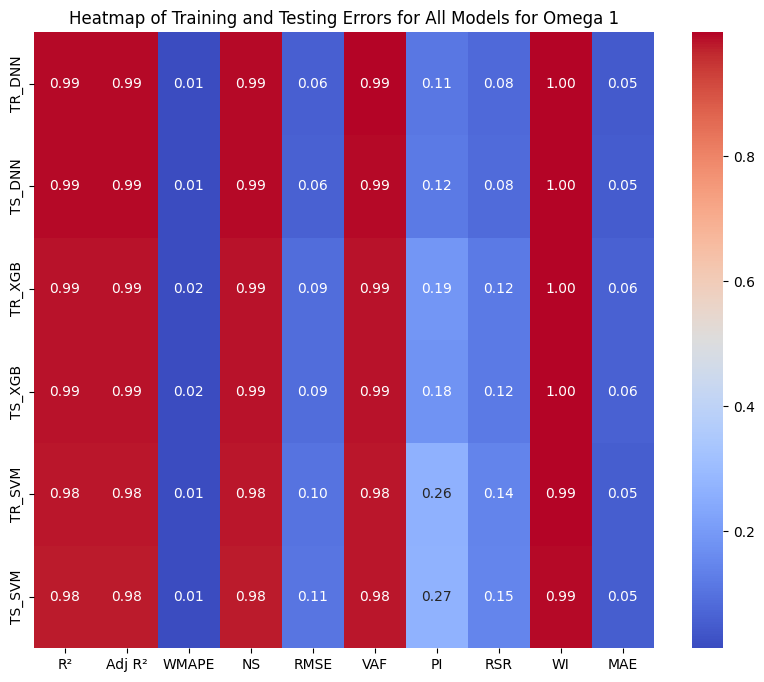

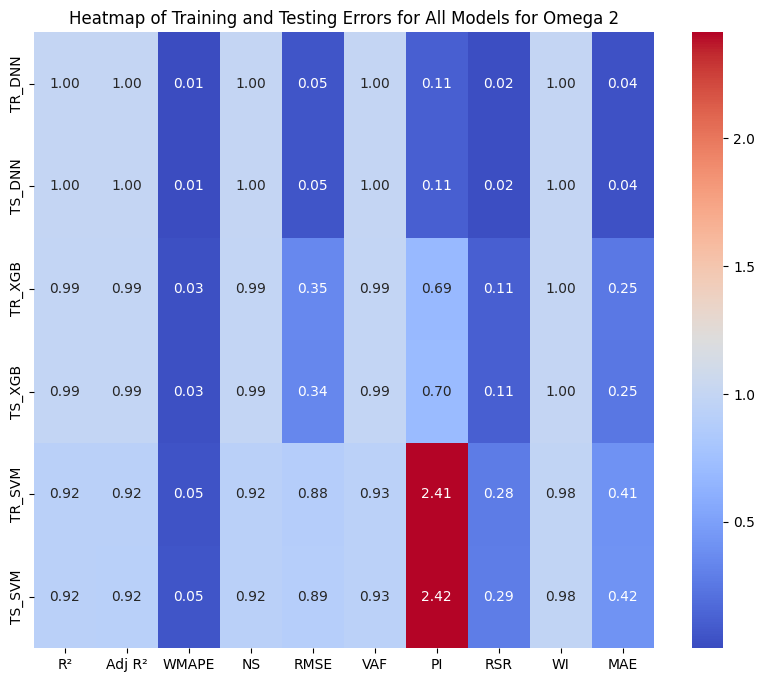

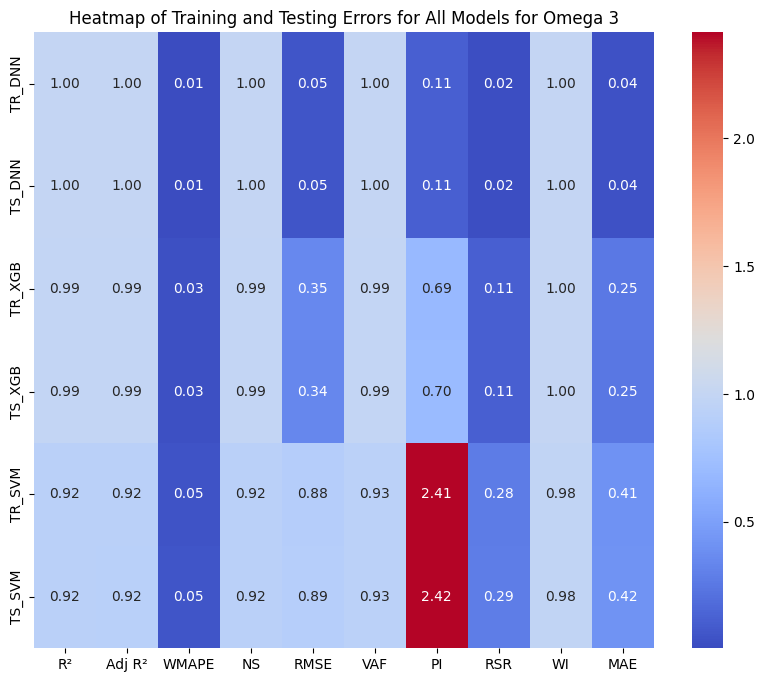

In [ ]:
import seaborn as sns

metrics_names = ["R²", "Adj R²", "WMAPE", "NS", "RMSE", "VAF", "PI", "RSR", "WI", "MAE"]
configurations1 = ["TR_DNN", "TS_DNN", "TR_XGB", "TS_XGB", "TR_SVM", "TS_SVM"]
configurations2 = ["TR_DNN", "TS_DNN", "TR_XGB", "TS_XGB", "TR_SVM", "TS_SVM"]
configurations3 = ["TR_DNN", "TS_DNN", "TR_XGB", "TS_XGB", "TR_SVM", "TS_SVM"]

# Each model (DNN, XGBoost, SVM) has errors for each configuration (omega3, omega2, omega3)
data1 = [Y1_train_metrics_dnn, Y1_test_metrics_dnn, Y1_train_metrics_xgb, Y1_test_metrics_xgb, Y1_train_metrics_svm, Y1_test_metrics_svm]
data2 = [Y2_train_metrics_dnn, Y2_test_metrics_dnn, Y2_train_metrics_xgb, Y2_test_metrics_xgb, Y2_train_metrics_svm, Y2_test_metrics_svm]
data3 = [Y3_train_metrics_dnn, Y3_test_metrics_dnn, Y3_train_metrics_xgb, Y3_test_metrics_xgb, Y3_train_metrics_svm, Y3_test_metrics_svm]

# Create DataFrame
df1 = pd.DataFrame(data1, index=configurations1, columns=metrics_names)
df2 = pd.DataFrame(data2, index=configurations2, columns=metrics_names)
df3 = pd.DataFrame(data3, index=configurations3, columns=metrics_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df1, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap of Training and Testing Errors for All Models for Omega 1")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df2, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap of Training and Testing Errors for All Models for Omega 2")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df2, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap of Training and Testing Errors for All Models for Omega 3")
plt.show()



# Rank Analysis

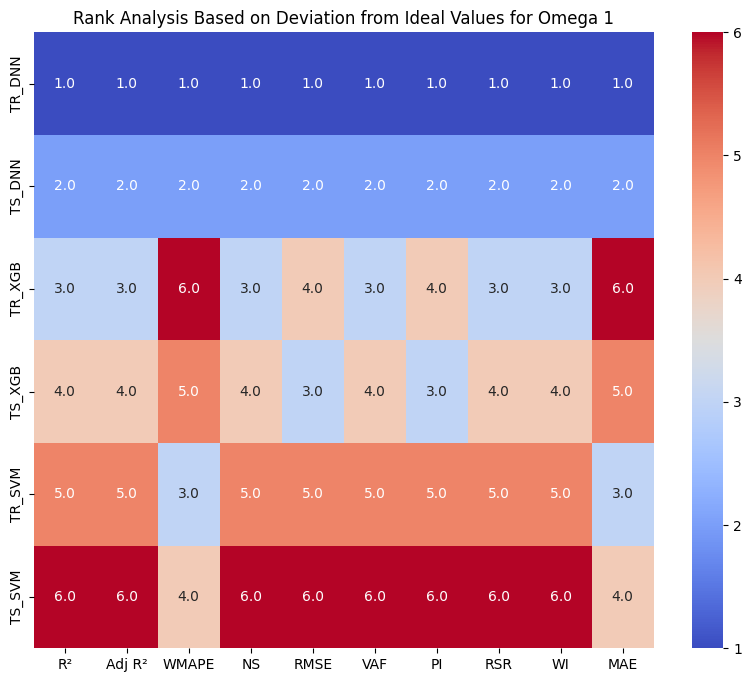

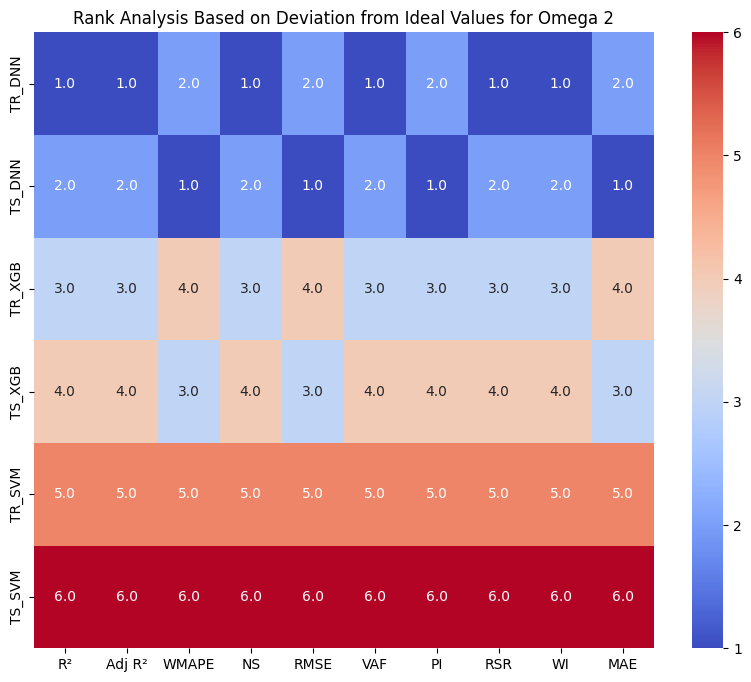

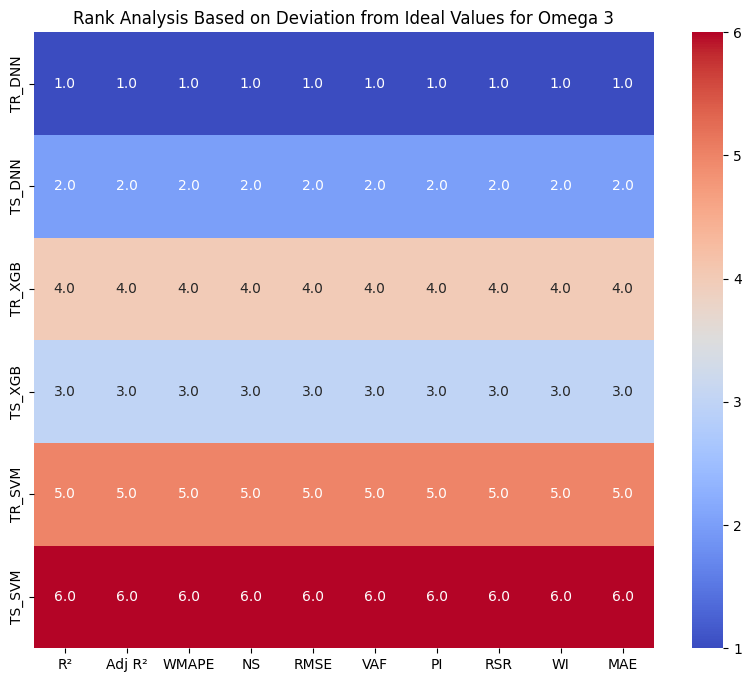

In [ ]:
# Define the ideal values for each metric
ideal_values = [1, 1, 0, 1, 0, 1, 0, 0, 1, 0]

# Calculate deviations from ideal values for omega1
deviation_df1 = np.abs(df1 - ideal_values)
deviation_df2 = np.abs(df2 - ideal_values)
deviation_df3 = np.abs(df3 - ideal_values)

# Perform rank analysis based on deviation
ranked_deviation_df1 = deviation_df1.rank(axis=0, ascending=True)
ranked_deviation_df2 = deviation_df2.rank(axis=0, ascending=True)
ranked_deviation_df3 = deviation_df3.rank(axis=0, ascending=True)

# Visualize the deviation ranks
plt.figure(figsize=(10, 8))
sns.heatmap(ranked_deviation_df1, annot=True, cmap="coolwarm", fmt=".1f", cbar=True)
plt.title("Rank Analysis Based on Deviation from Ideal Values for Omega 1")
plt.show()

# Visualize the deviation ranks
plt.figure(figsize=(10, 8))
sns.heatmap(ranked_deviation_df2, annot=True, cmap="coolwarm", fmt=".1f", cbar=True)
plt.title("Rank Analysis Based on Deviation from Ideal Values for Omega 2")
plt.show()

# Visualize the deviation ranks
plt.figure(figsize=(10, 8))
sns.heatmap(ranked_deviation_df3, annot=True, cmap="coolwarm", fmt=".1f", cbar=True)
plt.title("Rank Analysis Based on Deviation from Ideal Values for Omega 3")
plt.show()

